In [1]:
# !pip install -U gdown ultralytics scikit-learn albumentations

## 0. Download dataset

In [2]:
# # Download ICDAR 2003 dataset
# # https://drive.google.com/file/d/1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV/view
# !gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
# !unzip -q icdar2003.zip -d datasets

## 1. Import libraries

In [3]:
# %pip install -q -U ultralytics

In [4]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.52 🚀 Python-3.10.16 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3060, 11931MiB)
Setup complete ✅ (20 CPUs, 31.1 GB RAM, 592.5/915.3 GB disk)


In [5]:
# You can run this to check if the model is working
# !yolo predict model=yolo11n.pt source='https://ultralytics.com/images/bus.jpg'

In [6]:
import os
import shutil
import xml.etree.ElementTree as ET

import yaml
from sklearn.model_selection import train_test_split

## 2. Extract Data from XML and Store in YOLO format

In [7]:
def extract_data_from_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    image_paths = []
    image_sizes = []
    image_labels = []
    bounding_boxes = []

    for image in root:
        bbs_of_image = []
        labels_of_image = []

        for bbs in image.findall("taggedRectangles"):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                    continue

                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue

                bbs_of_image.append(
                    [
                        float(bb.attrib["x"]),
                        float(bb.attrib["y"]),
                        float(bb.attrib["width"]),
                        float(bb.attrib["height"]),
                    ]
                )
                labels_of_image.append(bb[0].text.lower())

        # Store
        image_paths.append(image[0].text)
        image_sizes.append((int(image[1].attrib["x"]), int(image[1].attrib["y"])))
        bounding_boxes.append(bbs_of_image)
        image_labels.append(labels_of_image)

    return image_paths, image_sizes, image_labels, bounding_boxes

In [8]:
dataset_dir = "datasets/SceneTrialTrain"
words_xml_path = os.path.join(dataset_dir, "words.xml")
image_paths, image_sizes, image_labels, bounding_boxes = extract_data_from_xml(
    words_xml_path
)

In [9]:
print(f"Number of images: {len(image_paths)}")
print(f"Example image path: {image_paths[0]}")
print(f"Example image size: {image_sizes[0]}")
print(f"Example bounding boxes: {bounding_boxes[0][:2]}")
print(f"Example labels: {image_labels[0][:2]}")

Number of images: 250
Example image path: apanar_06.08.2002/IMG_1261.JPG
Example image size: (1600, 1200)
Example bounding boxes: [[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0]]
Example labels: ['self', 'adhesive']


## 3. Convert to YOLO format

In [10]:
def convert_to_yolo_format(image_paths, image_sizes, bounding_boxes):
    yolo_data = []

    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        yolo_labels = []

        for bbox in bboxes:
            x, y, w, h = bbox

            # Calculate normalized bounding box coordinates
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Because we only have one class, we set class_id to 0
            class_id = 0

            # Convert to YOLO format
            yolo_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolo_labels.append(yolo_label)

        yolo_data.append((image_path, yolo_labels))

    return yolo_data

In [11]:
# Define class labels
class_labels = ["text"]

# Convert data into YOLO format
yolo_data = convert_to_yolo_format(image_paths, image_sizes, bounding_boxes)

## 4. Train, val, test split

In [12]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True
train_data, test_data = train_test_split(
    yolo_data, test_size=val_size, random_state=seed, shuffle=is_shuffle
)
test_data, val_data = train_test_split(
    test_data, test_size=test_size, random_state=seed, shuffle=is_shuffle
)

## 5. Save data

In [13]:
def save_data(data, src_img_dir, save_dir):
    # Create folder if not exists
    os.makedirs(save_dir, exist_ok=True)

    # Make images and labels folder
    os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "labels"), exist_ok=True)

    for image_path, yolo_labels in data:
        # Copy image to images folder
        shutil.copy(
            os.path.join(src_img_dir, image_path), os.path.join(save_dir, "images")
        )

        # Save labels to labels folder
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, "labels", f"{image_name}.txt"), "w") as f:
            for label in yolo_labels:
                f.write(f"{label}\n")

In [14]:
save_yolo_data_dir = "datasets/yolo_data"
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(save_yolo_data_dir, "train")
save_val_dir = os.path.join(save_yolo_data_dir, "val")
save_test_dir = os.path.join(save_yolo_data_dir, "test")

save_data(train_data, dataset_dir, save_train_dir)
save_data(test_data, dataset_dir, save_val_dir)
save_data(val_data, dataset_dir, save_test_dir)

## 6. Create yaml file

In [15]:
data_yaml = {
    "path": "./datasets/yolo_data",
    "train": "train/images",
    "test": "test/images",
    "val": "val/images",
    "nc": 1,
    "names": class_labels,
}

yolo_yaml_path = os.path.join(save_yolo_data_dir, "data.yml")
with open(yolo_yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

## 7. Training

In [17]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11m.pt")

# Train model
results = model.train(
    data=yolo_yaml_path,
    epochs = 100,
    imgsz = 640,
    cache = True,
    patience = 20,
    plots = True,
)

Ultralytics 8.3.52 🚀 Python-3.10.16 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3060, 11931MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=datasets/yolo_data/data.yml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

train: Scanning /home/aivn12s2/Desktop/Duc/AIO/Module-6/Image-Project/datasets/yolo_data/train/labels.cache... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.2GB RAM): 100%|██████████| 200/200 [00:00<00:00, 2353.48it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/aivn12s2/Desktop/Duc/AIO/Module-6/Image-Project/datasets/yolo_data/val/labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 43/43 [00:00<00:00, 1369.45it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.92G      2.179       3.14      1.845         47        640: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         43        200      0.609       0.63      0.635      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.09G      1.246      1.503       1.17         89        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         43        200      0.182       0.43      0.122     0.0643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      9.02G      1.246      1.359      1.176         61        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

                   all         43        200      0.186       0.41      0.165     0.0662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.98G      1.303      1.253      1.215         62        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

                   all         43        200      0.186       0.41      0.165     0.0662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.99G       1.31       1.26      1.227         44        640: 100%|██████████| 13/13 [00:04<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         43        200     0.0192       0.03     0.0047    0.00144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.02G      1.343      1.273       1.28         59        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         43        200      0.383      0.258      0.223      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.06G      1.382      1.265      1.288         52        640: 100%|██████████| 13/13 [00:04<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

                   all         43        200      0.551      0.265      0.232      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.99G      1.303      1.223      1.242         65        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]

                   all         43        200      0.551      0.265      0.232      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.09G      1.417      1.179      1.264         60        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         43        200    0.00719      0.005   0.000672   0.000357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.03G      1.305      1.128      1.217         32        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

                   all         43        200     0.0133       0.02    0.00137   0.000678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.02G      1.293      1.081      1.209         57        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

                   all         43        200      0.292       0.26      0.158     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.02G       1.25      1.063      1.192         60        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         43        200      0.111      0.155     0.0354     0.0134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.05G      1.249      1.083      1.154         51        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         43        200      0.442      0.325      0.282      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.03G      1.203     0.9937      1.159         51        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         43        200      0.536      0.625      0.539      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.03G      1.316      1.063      1.212         52        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         43        200      0.546      0.685      0.557      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.03G      1.211      1.047      1.151         28        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

                   all         43        200      0.586      0.615      0.553      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.98G      1.222      1.055      1.154         86        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         43        200      0.624      0.665      0.615      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.99G      1.192      1.016      1.142         28        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         43        200      0.663       0.71      0.727      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.99G      1.176      1.054      1.156         47        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

                   all         43        200      0.759      0.645      0.747      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.99G      1.147     0.9647      1.144         37        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         43        200      0.745       0.76      0.804      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         9G      1.122     0.8782      1.106         35        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         43        200      0.711      0.712      0.742      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.03G      1.113     0.9018      1.128         91        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         43        200       0.69      0.855      0.753      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.02G      1.126     0.8986      1.144         25        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         43        200      0.707       0.83      0.783      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.02G      1.091     0.8801      1.088         32        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         43        200      0.795       0.81      0.806      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.98G      1.055     0.8148      1.082         26        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         43        200      0.703      0.496      0.614      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.05G      1.029     0.8352      1.071         44        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         43        200      0.837       0.85      0.853      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      9.02G     0.9942      0.774       1.07         43        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         43        200      0.792      0.835      0.835      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.02G     0.9724     0.8098      1.057         45        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         43        200      0.848       0.84       0.85      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      9.07G      1.018     0.7993      1.083         44        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         43        200      0.831       0.82      0.832      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.02G     0.9845     0.7897      1.071         66        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         43        200      0.751      0.786      0.799      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.09G     0.9706     0.8073      1.071         56        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

                   all         43        200      0.838      0.745      0.839      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.99G     0.9925     0.7603      1.047         60        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         43        200      0.774      0.857      0.807       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.99G     0.9805     0.7818      1.052         47        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

                   all         43        200      0.822      0.825      0.858      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.99G     0.9672     0.7679      1.057         85        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         43        200      0.855      0.882      0.887      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.99G     0.9986     0.7661       1.06         32        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         43        200      0.878      0.825      0.866      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      9.02G     0.9457     0.7378      1.039         63        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         43        200      0.798      0.831      0.831       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.97G     0.9474     0.7372      1.057         52        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         43        200       0.81       0.79      0.842      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      9.04G     0.9661     0.7335      1.033         52        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         43        200      0.875      0.805      0.862      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.02G     0.9356     0.7334      1.038         31        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

                   all         43        200      0.832       0.87      0.883      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      9.02G     0.9339     0.7475       1.04         60        640: 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         43        200      0.826      0.855      0.859      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.98G     0.9331     0.6887      1.019         76        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

                   all         43        200      0.853      0.873      0.891      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.01G     0.9185     0.6817      1.006         75        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         43        200      0.848      0.865      0.871      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.99G     0.9118      0.707       1.02         73        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         43        200      0.837      0.824      0.854       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      9.02G     0.8783     0.6795      1.013         60        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

                   all         43        200      0.775       0.92      0.865      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      9.05G     0.9179     0.6383      0.997         76        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         43        200      0.831       0.84      0.847      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      9.05G     0.9237     0.6819      1.006         75        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         43        200      0.796       0.88      0.853      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.02G     0.8957     0.6533      1.009        111        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         43        200      0.827        0.9      0.881      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      9.02G     0.8962     0.6555      1.013         74        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         43        200      0.856      0.895      0.907      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.98G     0.8759      0.657     0.9984         37        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         43        200      0.885      0.846        0.9      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.99G     0.8633     0.6285      1.014         63        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         43        200       0.86      0.892      0.902      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      9.05G     0.8239     0.6197     0.9867         31        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         43        200      0.876       0.91      0.913       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.05G     0.7887     0.5903     0.9743         34        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         43        200      0.887      0.903      0.907      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.98G     0.8093     0.6015     0.9906         59        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         43        200      0.886      0.865      0.901       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.99G     0.8143     0.5955     0.9669         65        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         43        200      0.913       0.87      0.905      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.02G     0.8197     0.6162     0.9903         65        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         43        200      0.896      0.908      0.912      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      9.02G     0.8007     0.5907     0.9634         43        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         43        200      0.885      0.875      0.904      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         9G     0.7974     0.5806     0.9814         58        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         43        200      0.882      0.899      0.907      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      9.04G     0.8056     0.5699     0.9775         55        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         43        200      0.911      0.855      0.898      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      9.02G      0.787     0.5624     0.9619         35        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         43        200       0.88      0.917      0.896      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      9.02G     0.7667      0.569     0.9786         55        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         43        200      0.899      0.905      0.904      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      9.06G     0.7973     0.5652     0.9677         75        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         43        200      0.898      0.923       0.92      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.99G      0.795      0.581     0.9746         34        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         43        200       0.83      0.927      0.897      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       9.1G     0.7791     0.5421     0.9499         62        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         43        200      0.862      0.872      0.891      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      9.03G     0.7637     0.5172     0.9671         39        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         43        200      0.887       0.87        0.9      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.98G     0.8049       0.55     0.9731         52        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         43        200      0.864      0.887      0.907      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      9.04G     0.7184     0.5182     0.9474         58        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         43        200      0.916      0.871      0.911      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      9.09G     0.7664     0.5418     0.9563         69        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         43        200      0.883      0.902        0.9      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      9.03G     0.7418     0.5215     0.9551         89        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         43        200      0.869      0.928      0.918      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.99G     0.7836     0.5474     0.9777         49        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         43        200      0.873       0.94      0.929      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      9.02G     0.7322     0.5176     0.9478         30        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         43        200      0.893       0.94      0.929      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      9.02G      0.724      0.512     0.9578         57        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         43        200      0.896      0.925      0.916      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      9.03G     0.7464     0.5298     0.9503         49        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         43        200      0.857      0.945      0.906      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.97G      0.699     0.5049     0.9423         30        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         43        200      0.903      0.865        0.9      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       9.1G     0.7196     0.5069     0.9486         60        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         43        200      0.902       0.87      0.897       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      9.02G     0.7371     0.4998     0.9393         72        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         43        200      0.903       0.89      0.912      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      9.02G     0.7091     0.5034     0.9441         41        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         43        200      0.909      0.875      0.912        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      9.06G     0.6888     0.4772      0.931         83        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         43        200      0.898       0.88      0.904        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      9.04G     0.7138     0.5156     0.9464         64        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         43        200      0.867        0.9      0.922      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      9.02G     0.6853     0.4778     0.9318         38        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         43        200      0.865      0.915      0.922      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      9.05G     0.6992     0.4705     0.9357         65        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         43        200      0.891      0.861      0.916      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.94G     0.6953     0.5008      0.948         55        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         43        200      0.884      0.918       0.92      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      9.02G     0.6677     0.4691     0.9229         85        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         43        200       0.89      0.935      0.924      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      9.11G     0.6632     0.4628      0.926         33        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         43        200      0.895       0.92      0.931      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      9.02G     0.6724     0.4811     0.9384         55        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         43        200       0.88      0.916       0.93       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      9.06G     0.6617     0.4611     0.9199         58        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         43        200        0.9      0.895      0.925      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      9.04G      0.667     0.4537     0.9228         72        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

                   all         43        200      0.893      0.914      0.928      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.99G     0.6992     0.4664      0.938         94        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         43        200      0.867      0.943       0.93      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      9.02G     0.6629     0.4471     0.9408         48        640: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         43        200      0.916      0.868      0.933      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.98G     0.6346     0.4406      0.908         23        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         43        200      0.871       0.91      0.933      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      9.02G     0.6207      0.438      0.924         42        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         43        200      0.874      0.936      0.933       0.73


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      9.04G     0.7149     0.4949     0.9206         50        640: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         43        200      0.889       0.92      0.936      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      9.06G      0.682      0.487     0.9222         19        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         43        200      0.875      0.935       0.94      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.97G     0.6683     0.4821     0.9163         54        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         43        200      0.878       0.93      0.936      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      9.02G     0.6748     0.4797     0.9235         26        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         43        200      0.884       0.93      0.932      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      9.02G     0.6537     0.4687     0.9031         21        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         43        200      0.927      0.888      0.925      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.99G     0.6478     0.4646      0.898         33        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

                   all         43        200      0.876      0.919      0.924       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.97G     0.6457     0.4435     0.8955         33        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         43        200      0.878       0.93      0.924       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      9.02G     0.6069     0.4378     0.9017         18        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         43        200       0.86      0.949      0.926      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      9.02G     0.6307     0.4292     0.8936         36        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         43        200       0.87      0.945      0.924      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      9.05G     0.6716     0.4822     0.9127         40        640: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         43        200      0.863       0.95      0.922       0.73



100 epochs completed in 0.149 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.52 🚀 Python-3.10.16 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3060, 11931MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]


                   all         43        200      0.878       0.93      0.936      0.745
Speed: 0.8ms preprocess, 6.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train


## 8. Evaluation

In [19]:
from ultralytics import YOLO

model_path = "runs/detect/train/weights/best.pt"
model = YOLO(model_path)

metrics = model.val()

Ultralytics 8.3.52 🚀 Python-3.10.16 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3060, 11931MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


val: Scanning /home/aivn12s2/Desktop/Duc/AIO/Module-6/Image-Project/datasets/yolo_data/val/labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


                   all         43        200      0.879       0.93      0.936      0.745
Speed: 1.7ms preprocess, 11.8ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val


## 9. Inference

In [20]:
import json

import cv2
import matplotlib.pyplot as plt


def visualize_bbox(
    img_path, predictions, conf_thres=0.8, font=cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction["confidence"]

        if conf_score < conf_thres:
            continue

        bbox = prediction["box"]
        xmin = int(bbox["x1"])
        ymin = int(bbox["y1"])
        xmax = int(bbox["x2"])
        ymax = int(bbox["y2"])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(
            img,
            (xmin, ymin - text_height - 5),
            (xmin + text_width, ymin),
            (0, 255, 0),
            -1,
        )
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)

    return img

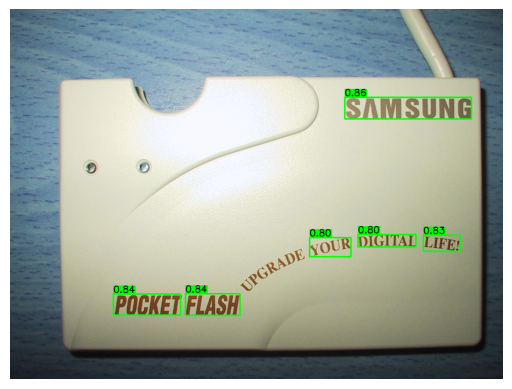

In [21]:
from ultralytics import YOLO

model_path = "runs/detect/train/weights/best.pt"
img_path = "datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1255.JPG"
conf_thres = 0.75
model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
predictions = json.loads(results[0].to_json())
visualized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis("off")
plt.show()